# **Loan Default Probability**
In this code I am using Multiple Model to Predict the probability that a loan will be default.

In [38]:
#Importing Required Libraries
import numpy as np
import pandas as pd
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#Disabling warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Importing the Dataset
df = read_csv('/content/LoansData.csv')
set_option('display.width', 100)
df.head(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(100000, 151)

In [6]:
#We will predict loan status, checking counts for this variable
df['loan_status'].value_counts(dropna = False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

We will focus on completed loans to learn differences between Fully Paid and Charged Off. So, we won't consider current, defaulted or loans having missing status.

In [8]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['loan_status'].value_counts(dropna = False)
df['loan_status'].value_counts(normalize = True, dropna = False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

As we can see that 81% of the remaining loans have been fully paid and 18% have charged off which indicates that the data is unbalanced.

In [9]:
df['charged_off'] = (df['loan_status'] == 'Charged Off').apply(np.uint8)
df.drop('loan_status', axis = 1, inplace=True)

The dataset has 150 features which increases the complexity of the model hence we need to eliminate features that do not contribute to prediction variable 

In [11]:
#Feature elimination by significant missing values
missing_fractions = df.isnull().mean().sort_values(ascending = False)
missing_fractions.head(10)

total_cu_tl                            1.0
annual_inc_joint                       1.0
sec_app_mths_since_last_major_derog    1.0
sec_app_collections_12_mths_ex_med     1.0
sec_app_chargeoff_within_12_mths       1.0
open_rv_12m                            1.0
sec_app_num_rev_accts                  1.0
sec_app_open_act_il                    1.0
sec_app_revol_util                     1.0
sec_app_open_acc                       1.0
dtype: float64

In [12]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [13]:
len(drop_list)

58

In [14]:
df.drop(labels = drop_list, axis = 1, inplace = True)
df.shape

(86138, 93)

In [15]:
#Feature elimination based on the intutiveness
print(sorted(df.columns))

['Unnamed: 0', 'acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_

In [16]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]
len(keep_list)

40

In [17]:
drop_list = [col for col in df.columns if col not in keep_list]
df.drop(labels = drop_list, axis = 1, inplace = True)
df.shape

(86138, 39)

In [19]:
#Feature elimination based on correlation
correlation = df.corr()
correlation_chargeOff = abs(correlation['charged_off'])
correlation_chargeOff.sort_values(ascending = False)

charged_off              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
loan_amnt                0.060818
funded_amnt              0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
id                       0.002221
Name: charged_off, dtype: float64

In [20]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
print(drop_list_corr)

['id', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']


In [21]:
df.drop(labels = drop_list_corr, axis = 1, inplace = True)
df.shape

(86138, 34)

In [23]:
#Performing EDA
df.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358,0.187559
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598,0.390362
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000,0.000000
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000,0.000000
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000,0.000000
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000,1.000000


In [25]:
#Analyzing categorical features
df[['emp_title','title','zip_code']].describe()

,emp_title,title,zip_code
count,81416,86138,86138
unique,32987,20,846
top,Teacher,Debt consolidation,750xx
freq,1576,52990,954


In [27]:
#The above features have lot of unique values. So, we drop them
df.drop(['emp_title','title','zip_code'], axis=1, inplace=True)

In [28]:
#Feature term
df['term'] = df['term'].apply(lambda s : np.int8(s.split()[0]))
df.groupby('term')['charged_off'].value_counts(normalize = True).loc[ : , 1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

<AxesSubplot:xlabel='emp_length'>

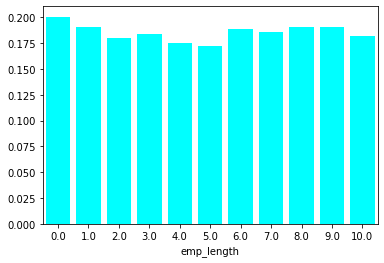

In [29]:
#Feature Employment Length
df['emp_length'].replace(to_replace = '10+ years', value = '10 years', inplace = True)
df['emp_length'].replace('< 1 year', '0 years', inplace = True)

def emp_length_to_int(s):
  if pd.isnull(s):
    return s
  else:
    return np.int8(s.split()[0])
    
df['emp_length'] = df['emp_length'].apply(emp_length_to_int)

charge_off_rates = df.groupby('emp_length')['charged_off'].value_counts(normalize = True).loc[ : , 1]
sns.barplot(x = charge_off_rates.index, y = charge_off_rates.values, color = 'cyan', saturation = 1)

Loan status does not appear to vary much with employment length on average, hence it is dropped.

In [30]:
df.drop(['emp_length'], axis = 1, inplace = True)

<AxesSubplot:xlabel='sub_grade'>

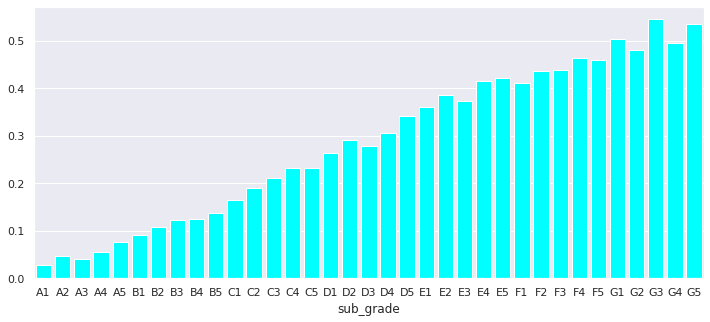

In [31]:
#Feature Subgrade
charge_off_rates = df.groupby('sub_grade')['charged_off'].value_counts(normalize = True).loc[ : , 1]
sns.set(rc = {'figure.figsize' : (12, 5)})
sns.barplot(x = charge_off_rates.index, y = charge_off_rates.values, color = 'cyan', saturation = 1)


There's a clear trend of higher probability of charge-off as the subgrade worsens.

In [32]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda s : int(s[-4 : ]))

In [33]:
#Feature Annual Income
df[['annual_inc']].describe()

,annual_inc
count,8.613800e+04
mean,7.384311e+04
std,5.929352e+04
min,4.000000e+03
25%,4.500000e+04
50%,6.247372e+04
75%,9.000000e+04
max,7.500000e+06


In [35]:
#Due to large range of income we take log transform
df['log_annual_inc'] = df['annual_inc'].apply(lambda x : np.log10(x + 1))
df.drop('annual_inc', axis = 1, inplace = True)

In [36]:
#FICO Score
df[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores.

In [37]:
df['fico_score'] = 0.5 * df['fico_range_low'] + 0.5 * df['fico_range_high']
df.drop(['fico_range_high', 'fico_range_low'], axis = 1, inplace = True)
df['charged_off'].value_counts()

0    69982
1    16156
Name: charged_off, dtype: int64

In [39]:
#Encoding Categorical Data
#Categorical boolean mask
categorical_feature_mask = df.dtypes == object
#Filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [40]:
le = LabelEncoder()
#Apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col : le.fit_transform(col))
df[categorical_cols].head(10)

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,2,10,3,1,2,40,1,0
1,0,2,1,0,1,4,1,0
2,3,15,3,1,1,21,1,0
4,2,12,3,1,2,3,0,0
5,2,12,3,1,2,26,0,0
6,1,9,1,1,3,20,0,0
7,1,8,2,2,2,40,1,0
8,2,13,3,1,1,42,0,0
9,1,8,3,0,2,18,0,0
10,1,9,3,2,2,19,0,0


In [41]:
df.shape

(86138, 29)

In [44]:
#Sampling Data
loanstatus_0 = df[df["charged_off"]==0]
loanstatus_1 = df[df["charged_off"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
df = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
df = df.sample(frac = 1).reset_index(drop = True)
print("Current shape of dataset :", df.shape)
df.head()

Current shape of dataset : (11000, 29)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,6300.0,6300.0,36,13.35,213.34,2,11,3,2,1,...,7803.0,2742.0,16.9,161.0,15.0,0.0,1.0,1,4.769385,677.0
1,24000.0,24000.0,36,6.49,735.47,0,1,1,1,2,...,21288.0,5709.0,71.0,121.0,4.0,2.0,7.0,0,5.124181,677.0
2,11400.0,11400.0,60,23.43,324.20,5,25,1,0,2,...,13806.0,3178.0,86.8,408.0,10.0,6.0,6.0,1,4.414990,717.0
3,22500.0,22500.0,60,17.57,566.11,3,18,1,1,3,...,6016.0,4702.0,48.9,137.0,3.0,3.0,12.0,1,4.785337,672.0
4,9000.0,9000.0,36,7.49,279.92,0,3,3,1,2,...,3802.0,31774.0,30.5,258.0,17.0,1.0,4.0,0,4.812920,732.0


In [45]:
#Filling the NAs with the mean of the column.
df.fillna(df.mean(), inplace = True)

In [47]:
#Defining Dependent and Independent Variables i.e. 'Y' and 'x' resp. & splitting the data for training and testing
Y= df["charged_off"]
X = df.loc[ : , df.columns != 'charged_off']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = validation_size, random_state = seed)

In [48]:
df['charged_off'].value_counts()

1    5500
0    5500
Name: charged_off, dtype: int64

In [49]:
#Test options for classification
num_folds = 10
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

In [50]:
#Applying Models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Ensable Models 
# Boosting methods
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))

In [52]:
#K-folds cross validation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits = num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.902158 (0.010008)
KNN: 0.813464 (0.012544)
CART: 0.809678 (0.008817)
NB: 0.900269 (0.009790)
GBM: 0.938489 (0.005817)
RF: 0.931093 (0.006113)


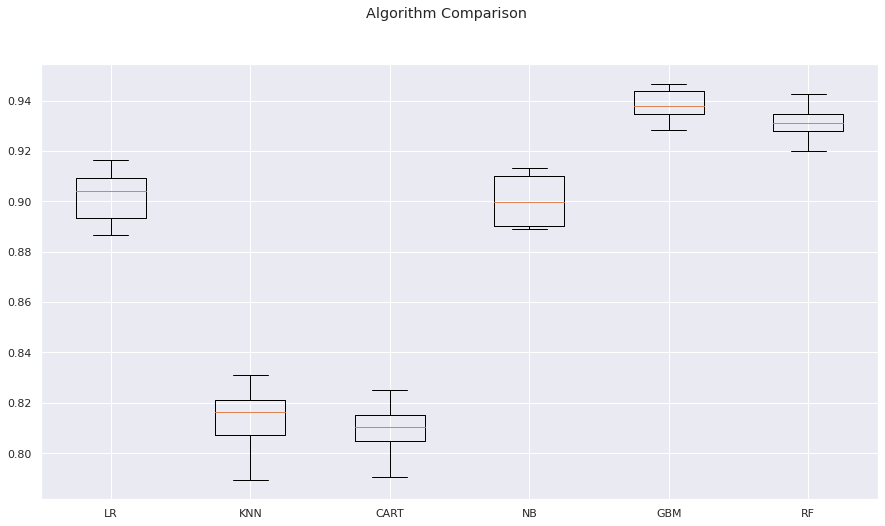

In [53]:
#Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

The Best Model Observed is Gradient Bossting Classifier.

In [55]:
#Tuning Hyper Parameters
n_estimators = [20, 180]
max_depth= [3, 5]
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits = num_folds)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.937562 using {'max_depth': 3, 'n_estimators': 180}
#4 0.928268 (0.006085) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.937562 (0.005608) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.934954 (0.005753) with: {'max_depth': 5, 'n_estimators': 20}
#2 0.937136 (0.006414) with: {'max_depth': 5, 'n_estimators': 180}


In [56]:
#Applying Model
model = GradientBoostingClassifier(max_depth = 3, n_estimators = 180)
model.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=180)

In [57]:
#Checking Accuracy
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8727272727272727
[[925 198]
 [ 82 995]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1123
           1       0.83      0.92      0.88      1077

    accuracy                           0.87      2200
   macro avg       0.88      0.87      0.87      2200
weighted avg       0.88      0.87      0.87      2200



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

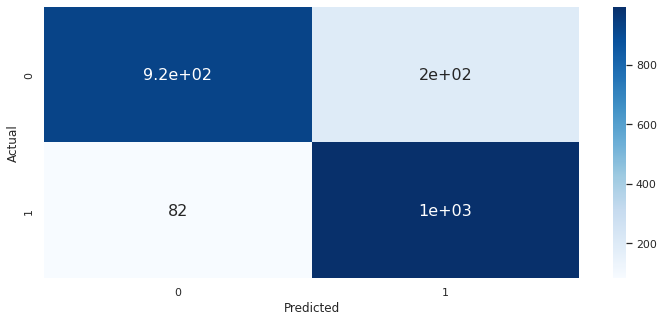

In [58]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns = np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap = "Blues", annot = True, annot_kws = {"size": 16})# font sizes

The results on the test set are quite good and the model performs much better with min case of default not caught.
